In [1]:
import scipy.io
import pandas as pd
from scipy.spatial.distance import squareform, cdist
import numpy as np
#import sklearn.neighbors.kneighbors_graph 
import matplotlib.pyplot as plt
from sklearn.utils.graph_shortest_path import  graph_shortest_path
import scipy.sparse.linalg as ll
from PIL import Image
from matplotlib.pyplot import imshow
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

In [2]:
def main(method = 'euclidean'):
    #reading the data
    mat = scipy.io.loadmat('isomap.mat')
    df = pd.DataFrame(mat['images']).T
    #rotating the images for nicer graphs
    '''
    I used parts of the code in the link http://benalexkeen.com/isomap-for-dimensionality-reduction-in-python
    in order to rotate the images.
    '''
    m, n = df.shape
    pixels_per_dimension = int(np.sqrt(n))

    for idx in df.index:
        df.loc[idx] = df.loc[idx].values.reshape(pixels_per_dimension, pixels_per_dimension).T.reshape(-1)
    
    #Creating the adjacency matrix and D - STEP 1
    dist_mat = cdist(df,df, metric=method)
    A = (dist_mat < np.percentile(dist_mat,14.3, axis =1, keepdims=True)).astype(int)
    neighbour_bool = (A == 1)
    bool_vec = neighbour_bool.reshape(1, neighbour_bool.shape[0]*neighbour_bool.shape[1])
    dist_vector = dist_mat.reshape(1, dist_mat.shape[0]*dist_mat.shape[1])
    dist_vector[~bool_vec] = np.inf
    A_alt = dist_vector.reshape(dist_mat.shape[0],dist_mat.shape[1])
    D = graph_shortest_path(A_alt)
    
    #STEP 2  - creating centering matrix 
    m = D.shape[0]
    I = np.eye(len(D))
    ones = np.ones(len(D)).reshape(1,-1)
    H = I - ones.T.dot(ones)/m
    D_sqrt = D**2
    C = - H.dot(D_sqrt.dot(H))/(2*m)
    
    #finding top 2 eigenvectors and eigenvalues
    S, W = ll.eigs(C, k=2)
    
    #Calculating the new dimensions
    dim1 = W[:,0]*np.sqrt(S[0])
    dim2 = W[:,1]*np.sqrt(S[1])
    
    fig = plt.figure(figsize=(10,12))
    fig.set_size_inches(10, 10)
    ax = fig.add_subplot(111)

    # Show 2D components plot
    ax.scatter(dim1.real, dim2.real, marker='.',alpha=0.7)


    for _ in range(50):
        random_index = np.random.randint(df.shape[0])
        array_to_img = df.loc[random_index].values.reshape(64, 64)
        ab = AnnotationBbox(OffsetImage(array_to_img), (dim1[random_index].real, dim2[random_index].real),frameon=False)
        ax.add_artist(ab)

    


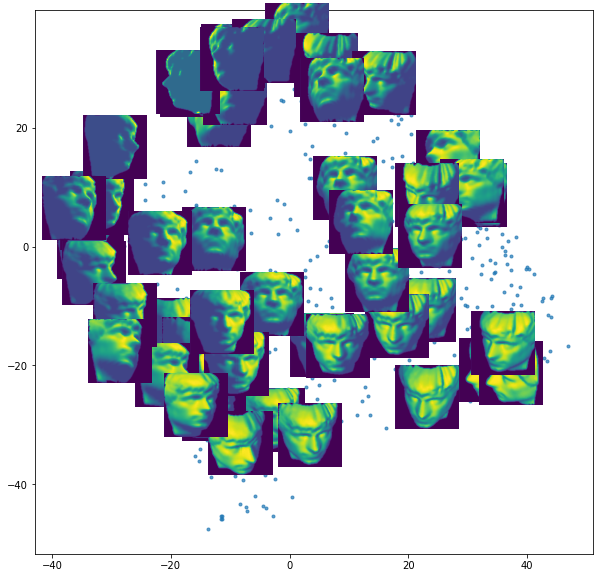

In [3]:
#manhattan distance
if __name__ == "__main__":
    main('cityblock')

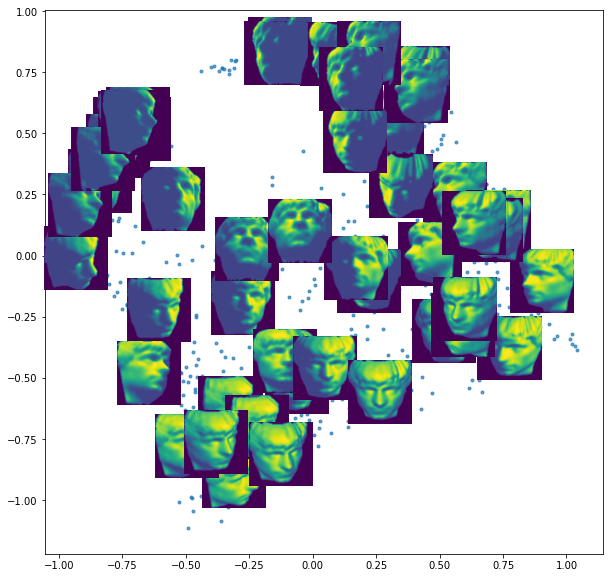

In [4]:
#euclidean distance
if __name__ == "__main__":
    main()